__Автор__: Карпаев Алексей, ассистент кафедры информатики и вычислительной математики

# Метод конечных элементов: численное решение ОДУ. Программная реализация, ОО подход

In [1]:
import numpy as np
import scipy.integrate as intgr
import scipy.sparse.linalg
import scipy.linalg
import math as m
import sympy as smp
import matplotlib.pyplot as plt
import timeit

plt.rc('font', size=20)

Определение классов для численного дифференцирования:

In [2]:
class AbstractDerivative:
    
    def __init__(self, f, h=1e-3):
        self.f = f
        self.h = float(h)
        self.maxStencilSize = 5
        self.coeffs = np.zeros(self.maxStencilSize)
        self._ConstructMethod()
        
        self.stencilPoints = np.array([self.h*i \
                                   for i in range(int(-(self.maxStencilSize - 1)/2), \
                                           int((self.maxStencilSize - 1)/2) + 1)])
  
    
    def _ConstructMethod(self):
        raise NotImplementedError
                                            
    def __call__(self, x):
        
        movedStencilPoints = self.stencilPoints + float(x)
                       
        value = 0.
        for i in range(self.maxStencilSize):
            value += self.coeffs[i]*self.f(movedStencilPoints[i])
        value /= self.h
        
        return value

In [3]:
''' # не используем: слишком долго считается при вызове внутри методов классов, 
# рассматриваемых ниже
class DerivativeCentral(AbstractDerivative):
    
    def _ConstructMethod(self):
        self.coeffs[1] = -1./2
        self.coeffs[3] = 1./2
'''

class DerivativeCentral:
    
    def __init__(self, f, h=1e-3):
        self.f = f
        self.h = float(h)
        
    def __call__(self, x):
        f, h = self.f, self.h
        return 1./(2.*h)*(f(x + h) - f(x - h))

Определение иерархии классов для численного интегрирования:

In [4]:
class AbstractIntegral:
    
    def __init__(self, f, xLeft, numBlocks):
        self.f = f
        self.xLeft = xLeft # xLeft = a
        self.numBlocks = numBlocks
        self.numPoints = self.numBlocks + 1
        self.coefficients = None

        print('Пустой объект класса ' + self.__class__.__name__ + ' создан.')
         
    
    def _ConstructMethod(self):
        raise NotImplementedError
          
            
    def __call__(self, x):
        h = (x - self.xLeft)/self.numBlocks
        
        self.f = np.vectorize(self.f) # раскомментировать, если функция из модуля math
        
        self._ConstructMethod(x)
        
        value = 0.
        
        start = timeit.default_timer()
        
        # вычисление интеграла
        value = np.dot(self.coefficients, self.f(self.gridPoints))
        value *= h
        
        timeElapsed = float(timeit.default_timer() - start)
        
        return value

In [5]:
class TrapeziumMethod(AbstractIntegral):
    
    def _ConstructMethod(self, x):
        self.gridPoints = np.linspace(self.xLeft, x, self.numPoints)
        
        self.coefficients = np.ones(self.numPoints)
        self.coefficients[0] *= 0.5
        self.coefficients[-1] *= 0.5

Определение класса для представления конечно-элементной сетки:

In [6]:
class FEMMesh:
    
    def __init__(self, xL, xR, numFEs):
        # равноотстоящие узлы
        self.numFEs = numFEs
        self.nodes = list(np.linspace(xL, xR, numFEs + 1))
        self.finiteElems = [ [self.nodes[i], self.nodes[i + 1]] \
                             for i in range(len(self.nodes) - 1)] 
        self.h = float(np.diff(self.nodes)[0])
    
    
    def __str__(self):
        counter = 0
        for elem in self.finiteElems:
            print('Elem #%d: [%.2f, %.2f]' % (counter, elem.xL, elem.xR))
            counter += 1

Определение класса для представления базисных функций-"шляпок":

In [7]:
class BasisFunction:
    
    # индекс "i" базисной функции: 1 <= i <= numNodes - 2
    def __init__(self, mesh, index):
        self.mesh = mesh
        self.i = index # "i" --- параметр
    
    def __call__(self, x):
        xArrayMesh = self.mesh.nodes # для краткости
        i = self.i # для краткости
        
        # функция-"шляпка"
        if i != 0 and i != len(xArrayMesh) - 1:
            if x >= xArrayMesh[i - 1] and x < xArrayMesh[i]:
                return (x - xArrayMesh[i - 1]) / self.mesh.h
            elif x >= xArrayMesh[i] and x < xArrayMesh[i + 1]:
                return 1. - (x - xArrayMesh[i]) / self.mesh.h
            else:
                return 0.
            

        # левая функция-"полушляпка"
        elif i == 0:
            if x >= xArrayMesh[0] and x < xArrayMesh[1]:
                return 1. - (x - xArrayMesh[i]) / self.mesh.h
            else: 
                return 0.
        
        
        # правая функция-"полушляпка"
        elif i == len(xArrayMesh) - 1:
            if x > xArrayMesh[-2] and x <= xArrayMesh[-1]:
                return (x - xArrayMesh[-2]) / self.mesh.h
            else: 
                return 0.
            
    
    def Plot(self):
        xL = self.mesh.nodes[0]
        xR = self.mesh.nodes[-1]
        
        xData = np.linspace(xL, xR, 100)
        yData = np.array([self(x) for x in xData])
        
        plt.figure(figsize=(9, 4))
        plt.plot(xData, yData, '-', lw=2)
        plt.grid(None)
        plt.show()

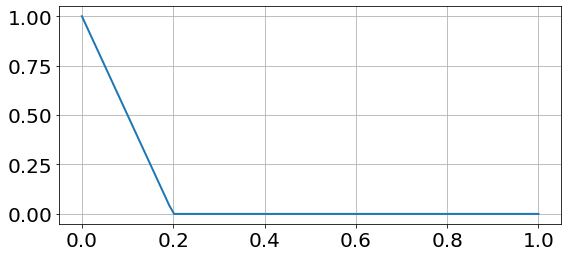

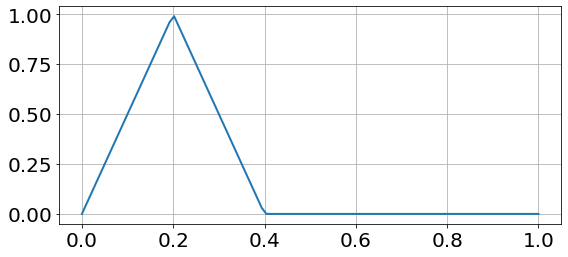

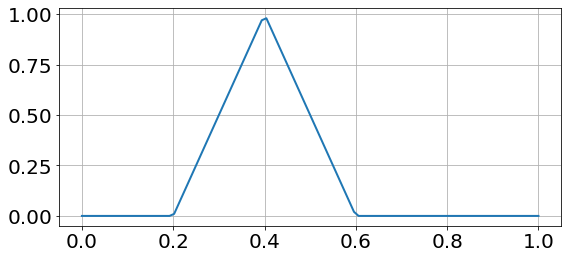

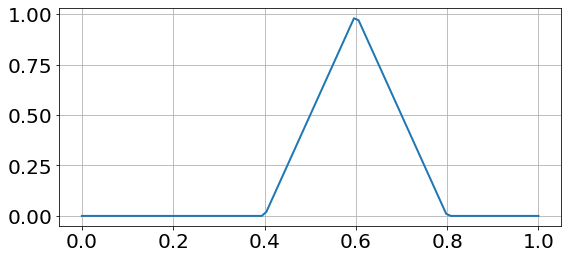

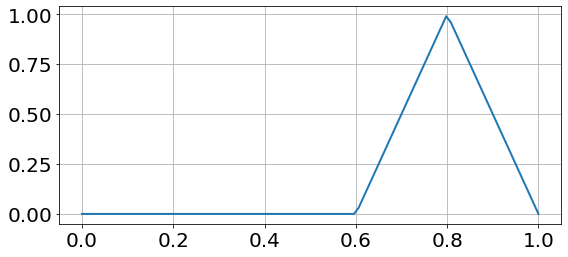

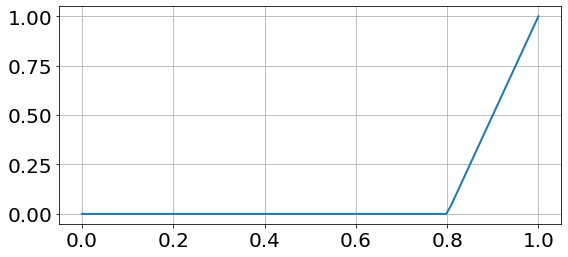

In [8]:
# построение графиков базисных функций
mesh1 = FEMMesh(xL=0., xR=1., numFEs=5)

for i in range(mesh1.numFEs + 1):
    f = BasisFunction(mesh=mesh1, index=i)
    f.Plot()

## Солверы
Создадим класс-солвер для нахождения коэффициентов __методом Галеркина__. Данный класс можно использовать в качестве заготовки для создания иерархии классов, в которую будут входить классы-солверы, в которых реализованы методы нахождения коэффициентов:
* коллокации
* наименьших квадратов (дискретный)
* наименьших квадратов
* Галеркина.

In [9]:
class FEMSolverGalerkin:
    
    def __init__(self, mesh, function, points):
        self.mesh = mesh
        self.f = function
        self.numNodes = len(self.mesh.nodes)
        
        
        self.BasisFuncs = [BasisFunction(self.mesh, i) \
                            for i in range(0, self.numNodes)]
        
        # инициализация объекта, производящего интегрирования
        self.integrationMethod = TrapeziumMethod(f=None, \
                                                 xLeft=self.mesh.nodes[0], \
                                                 numBlocks=int(1e3))
        

    
        
    def _SetupLinearSystem(self):
        self.S = np.zeros((self.numNodes, self.numNodes))
        self.b = np.zeros(self.numNodes)
        
        for i in range(1, self.numNodes - 1):
            # вычисление элементов матрицы жесткости
            for j in range(1, self.numNodes - 1):
                self.S[i, j] = self._StiffnessMatrixEntry(i, j)
    
            # вычисление элементов вектора нагрузки
            self.b[i] = self._LoadVectorEntry(i)
    
    
    def _StiffnessMatrixEntry(self, i, j):
        h0 = 1e-3
        self.integrationMethod.f = lambda t: \
                                    DerivativeCentral(self.BasisFuncs[i], h=h0)(t)* \
                                    DerivativeCentral(self.BasisFuncs[j], h=h0)(t) \
                                    
        value = self.integrationMethod(self.mesh.nodes[-1])
    
        return value
    
    
    def _LoadVectorEntry(self, i):
        self.integrationMethod.f = lambda t: \
                                    self.f(t)*self.BasisFuncs[i](t)

        value = self.integrationMethod(self.mesh.nodes[-1])
        
        return value
    
        
    
    def Solve(self):
        self._SetupLinearSystem()
        
        # $\alpha_i$, соответствующие функциям-"полушляпкам", равны нулю
        self.alphas = np.zeros(self.numNodes)
        
        # "быстрое" нахождние аналитич. решения СЛАУ
        # рассматриваем только "внутренню" подматрицу
        self.alphas[1:-1] = scipy.linalg.solve(self.S[1:-1, 1:-1], self.b[1:-1])
        #self.alphas = scipy.sparse.linalg.cg(self.S[1:-1, 1:-1], self.b[1:-1])[0]
        

    def EvaluateSolution(self, x):
        value = 0.
        
        
        for alpha, BasisFunc in zip(self.alphas, self.BasisFuncs):
            value += alpha*BasisFunc(x)
        return value
    
    
    def PlotSolution(self):
        xL = self.mesh.nodes[0]
        xR = self.mesh.nodes[-1]
        
        self.xData = np.linspace(xL, xR, 100)
        yData = np.array([self.EvaluateSolution(x) for x in self.xData])
        
        plt.plot(self.xData, yData, '-', lw=2, label=self.__class__.__name__)
        plt.legend()
        plt.grid(None)

Давайте получим краевую задачу 

$$
    -u''(x) = f, \quad x \in I = \left(0, 1 \right), \\
    u(0)=u(1)=0
$$

продифференцировав "старую знакомую", $u(x) \equiv x^2 sin(2 \pi x)$; последняя удовлетворяет граничным условиям.

### Использование

In [10]:
xSym = smp.Symbol('x')
# код для отображения формул в формате LaTex
smp.init_printing(use_latex='mathjax')
import IPython.display as ipy

In [11]:
testFuncSym = xSym**2 * smp.sin(2*smp.pi*xSym)
testFunc = smp.lambdify(xSym, testFuncSym)

print('Аналитическое решение u(x):')
ipy.display(testFuncSym)


orderDer = 2
rhsSym = -1*smp.diff(testFuncSym, xSym, orderDer) # производная порядка orderDer

print('Функция  правой части ОДУ f(x):' )
ipy.display(rhsSym)

Аналитическое решение u(x):


 2           
x ⋅sin(2⋅π⋅x)

Функция  правой части ОДУ f(x):


   ⎛     2  2                                           ⎞
-2⋅⎝- 2⋅π ⋅x ⋅sin(2⋅π⋅x) + 4⋅π⋅x⋅cos(2⋅π⋅x) + sin(2⋅π⋅x)⎠

Теперь проведем численное решение:

Пустой объект класса TrapeziumMethod создан.


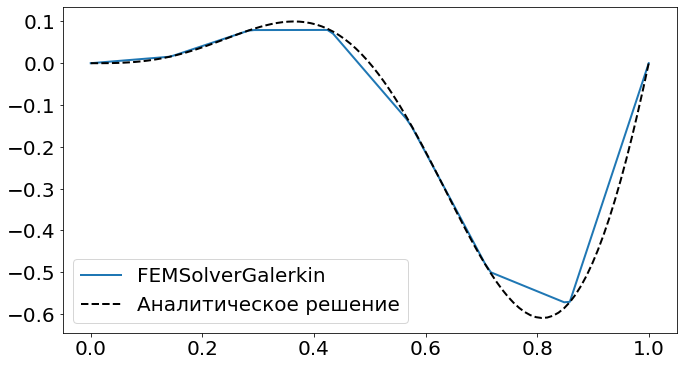

In [12]:
rhs = smp.lambdify(xSym, rhsSym)

mesh = FEMMesh(0., 1., numFEs=7)

plt.figure(figsize=(11, 6))
solver = FEMSolverGalerkin(mesh, rhs, points=None)
solver.Solve()
solver.PlotSolution()

   
# график аналитического решения
plt.plot(solver.xData, testFunc(solver.xData), 'k--', label='Аналитическое решение', lw=2)
plt.legend(loc='best')
plt.grid(None)
plt.show()

## Вопросы?